# ModelRadar Tutorial Part 2 - Analysis

This notebook applies modelradar to analyse the forecasting accuracy of different models across different dimensions.

### Preliminaries

- Starting by loading the libraries

In [1]:
import warnings 

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import plotnine as p9

from utilsforecast.losses import smape, mape

from modelradar.evaluate.radar import ModelRadar
from modelradar.visuals.plotter import ModelRadarPlotter, SpiderPlot

- Loading the cross-validation results obtained in the first part of this tutorial

In [2]:
cv = pd.read_csv('cv.csv')
cv['anomaly_status'] = cv['is_anomaly'].map({0: 'No anomalies', 1: 'With anomalies'})

cv.head()

,unique_id,ds,cutoff,NHITS,KAN,MLP,MLP1,y,SeasonalNaive,SeasonalNaive-lo-99,SeasonalNaive-hi-99,is_anomaly,anomaly_status
0,M1,1993-09-30,1993-08-31,2522.3760,2832.5632,2227.3872,2108.7034,4800.0,6720.0,-1538.656675,14978.656675,0,No anomalies
1,M1,1993-10-31,1993-08-31,2222.8090,2208.6550,1891.9187,1820.0846,3000.0,2040.0,-6218.656675,10298.656675,0,No anomalies
2,M1,1993-11-30,1993-08-31,2850.9258,3215.8845,2641.8730,2418.4226,3120.0,6480.0,-1778.656675,14738.656675,0,No anomalies
3,M1,1993-12-31,1993-08-31,2324.2947,2065.0460,1888.0807,1995.6719,5880.0,1920.0,-6338.656675,10178.656675,0,No anomalies
4,M1,1994-01-31,1993-08-31,2614.6120,2493.6558,2245.0667,2192.6226,2640.0,3600.0,-4658.656675,11858.656675,0,No anomalies


#### Setting up ModelRadar

Parameters:
- cv_df: input cross-validation data based on a nixtla structure
- metrics: forecasting evaluation metrics based on utilsforecast
- model_names: column names in **cv_df** of each model
- hardness_reference: model name used to define hard time series problems
- ratios_reference: model name used as benchmark
- rope: region of practical equivalence percentage, under which differences in performance are considered irrelevant

In [3]:
radar = ModelRadar(cv_df=cv,
                   freq='ME',
                   metrics=[smape, mape],
                   model_names=['NHITS', 'MLP', 'MLP1', 'KAN', 'SeasonalNaive'],
                   hardness_reference='SeasonalNaive',
                   ratios_reference='NHITS',
                   rope=10)

### Error across individual time series

- The **evaluate** method computes the accuracy of each model across each **unique_id** (individual time series)

In [4]:
err = radar.evaluate(keep_uids=True)

err.head()

,NHITS,MLP,MLP1,KAN,SeasonalNaive
unique_id,,,,,
M1,0.439107,0.435935,0.444822,0.414968,0.637229
M10,0.147671,0.179927,0.205323,0.166090,0.220193
M100,0.063144,0.061422,0.065762,0.060710,0.091640
M1000,0.006861,0.011640,0.031225,0.013771,0.023825
M1001,0.021155,0.023642,0.044886,0.027602,0.026164


- You can pass the **keep_uids** argument as False to get the overall accuracy

In [5]:
radar.evaluate(keep_uids=False)

NHITS            0.103926
MLP              0.103718
MLP1             0.107780
KAN              0.105538
SeasonalNaive    0.131472
Name: Overall, dtype: float64

- Use the **get_hard_uids** to get the scores on "hard" time series--those where the hardness_reference model performs worse

In [6]:
err_hard = radar.uid_accuracy.get_hard_uids(err)

err_hard.head()

,NHITS,MLP,MLP1,KAN,SeasonalNaive
unique_id,,,,,
M1,0.439107,0.435935,0.444822,0.414968,0.637229
M1057,0.192344,0.198739,0.173086,0.194882,0.367485
M1078,0.948928,0.948080,0.954298,0.915843,1.334853
M1079,0.671254,0.693894,0.693507,0.678374,0.901305
M1091,0.222902,0.249979,0.225307,0.253440,0.383909


- Another variant is to get the scores on time series with anomalous observations:

In [7]:
err_anomalies = radar.evaluate_by_anomaly(anomaly_col='is_anomaly', mode='observations')
# err_anomalies = radar.evaluate_by_anomaly(anomaly_col='is_anomaly', mode='series')

err_anomalies.head()

,NHITS,MLP,MLP1,KAN,SeasonalNaive
M1022,0.351695,0.345792,0.327587,0.349334,0.836546
M1026,0.072702,0.082830,0.109966,0.084609,0.104588
M1029,0.152476,0.158906,0.180949,0.149072,0.199230
M103,0.194814,0.216111,0.235769,0.216668,0.237137
M1030,0.078034,0.084170,0.120676,0.091201,0.105438


### Performance summary plots

Below are some plots that you can obtain using ModelRadar.

#### Overall accuracy

First, we show a barplot that illustrates the overall accuracy of each model. MLP performs best, with a small edge over NHITS.

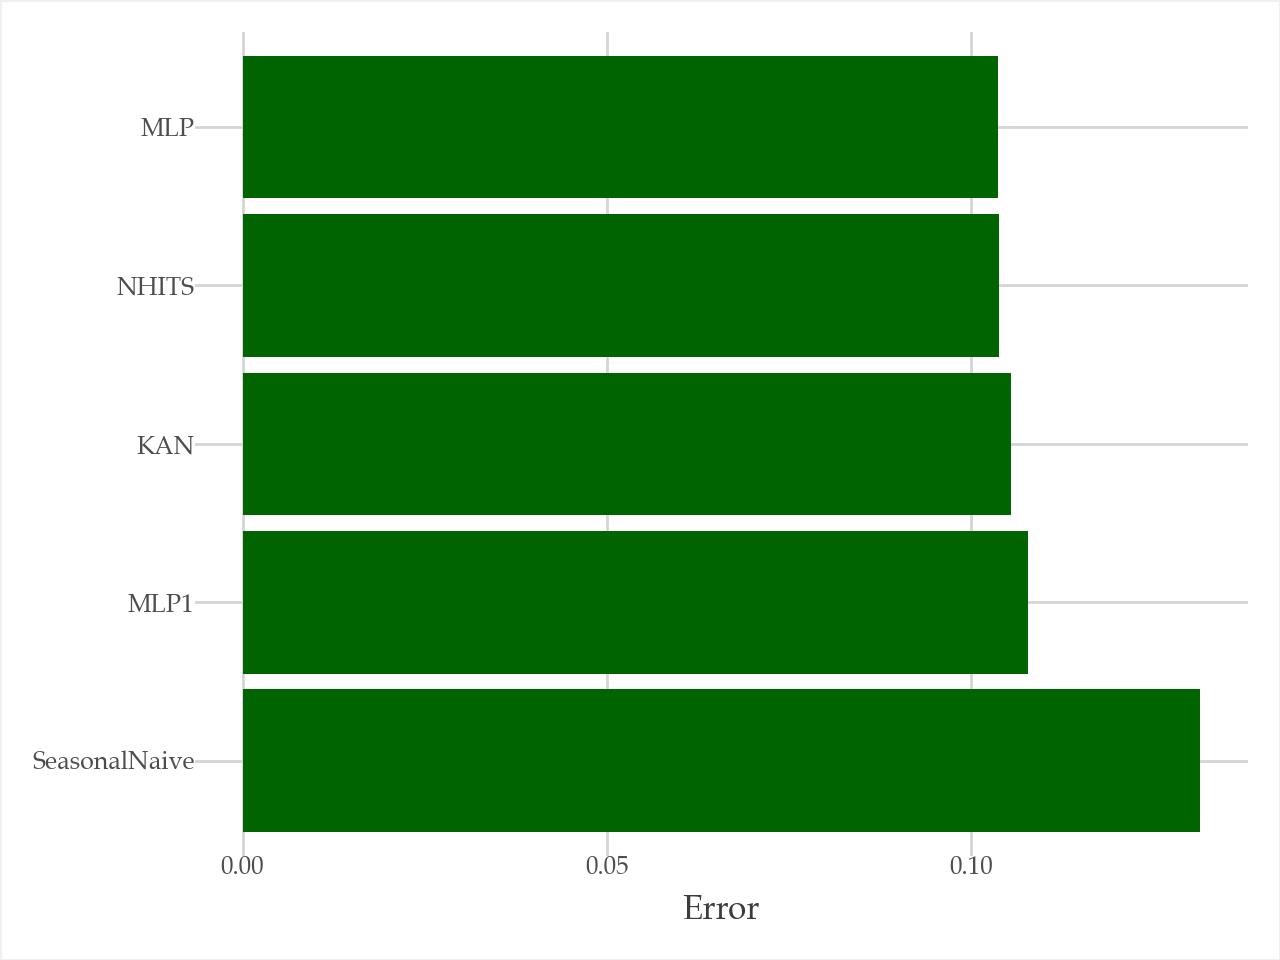

In [8]:
plot = radar.evaluate(return_plot=True)

plot

In [9]:
# pass return_plot=False to get the actual scores
eval_overall = radar.evaluate(return_plot=False)
eval_overall

NHITS            0.103926
MLP              0.103718
MLP1             0.107780
KAN              0.105538
SeasonalNaive    0.131472
Name: Overall, dtype: float64

#### Accuracy by horizon bound

We can split the analysis by forecasting horizon to check if relative performances are stable across this dimension.

While MLP shows the best overall score, the other neural models outperform it on a multi-step ahead forecasting setting.

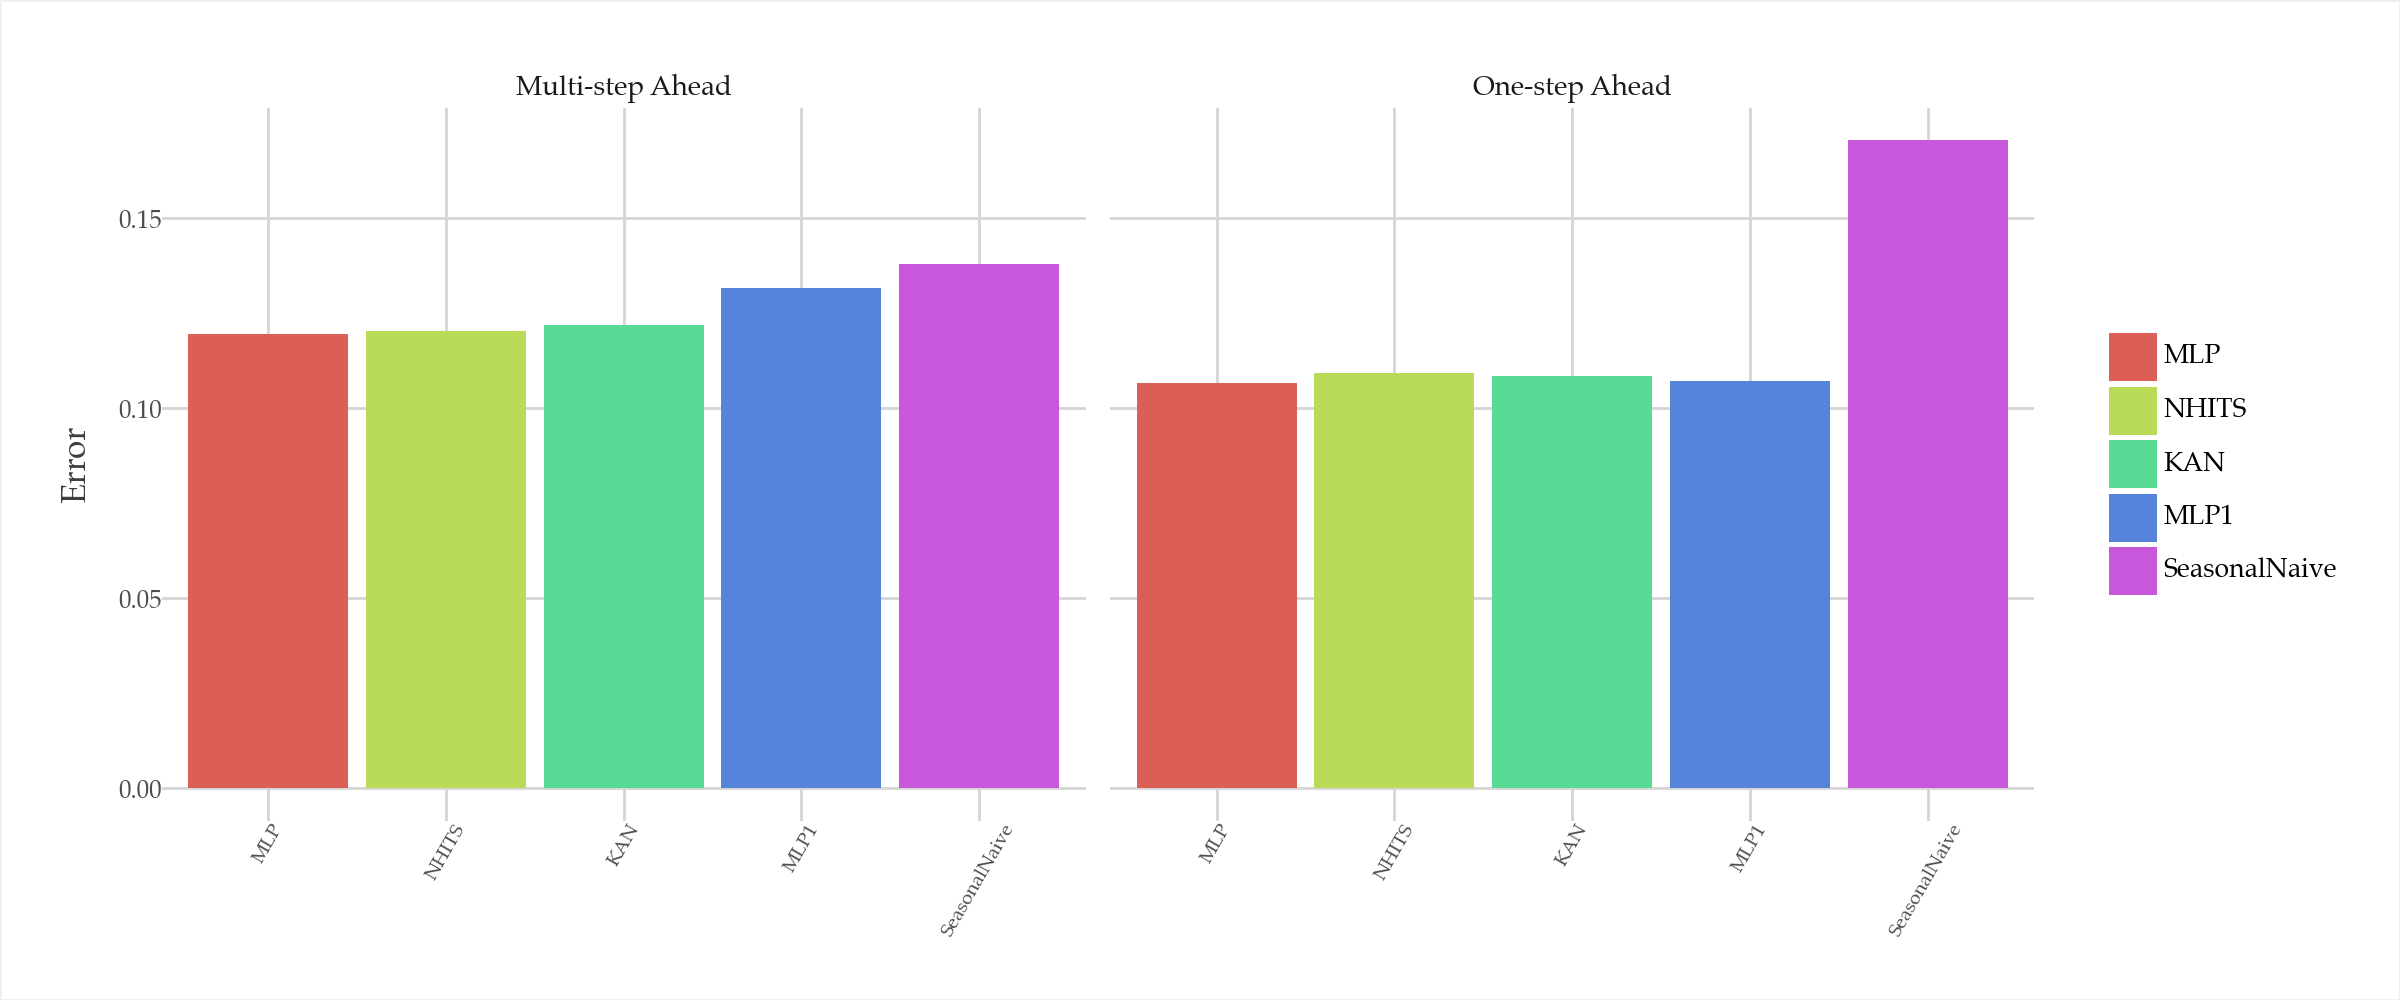

In [10]:
plot = radar.evaluate_by_horizon_bounds(return_plot=True, plot_model_cats=radar.model_order)

plot + p9.theme(figure_size= (12,5))

In [11]:
# getting the scores without plotting
eval_hbounds = radar.evaluate_by_horizon_bounds()
eval_hbounds

,One-step Ahead,Multi-step Ahead
Model,,
NHITS,0.109337,0.120247
MLP,0.106710,0.119563
MLP1,0.107053,0.131621
KAN,0.108487,0.121960
SeasonalNaive,0.170502,0.137894


#### Accuracy across horizon point

The evaluate_by_horizon method shows the accuracy of each model across the forecasting horizon.

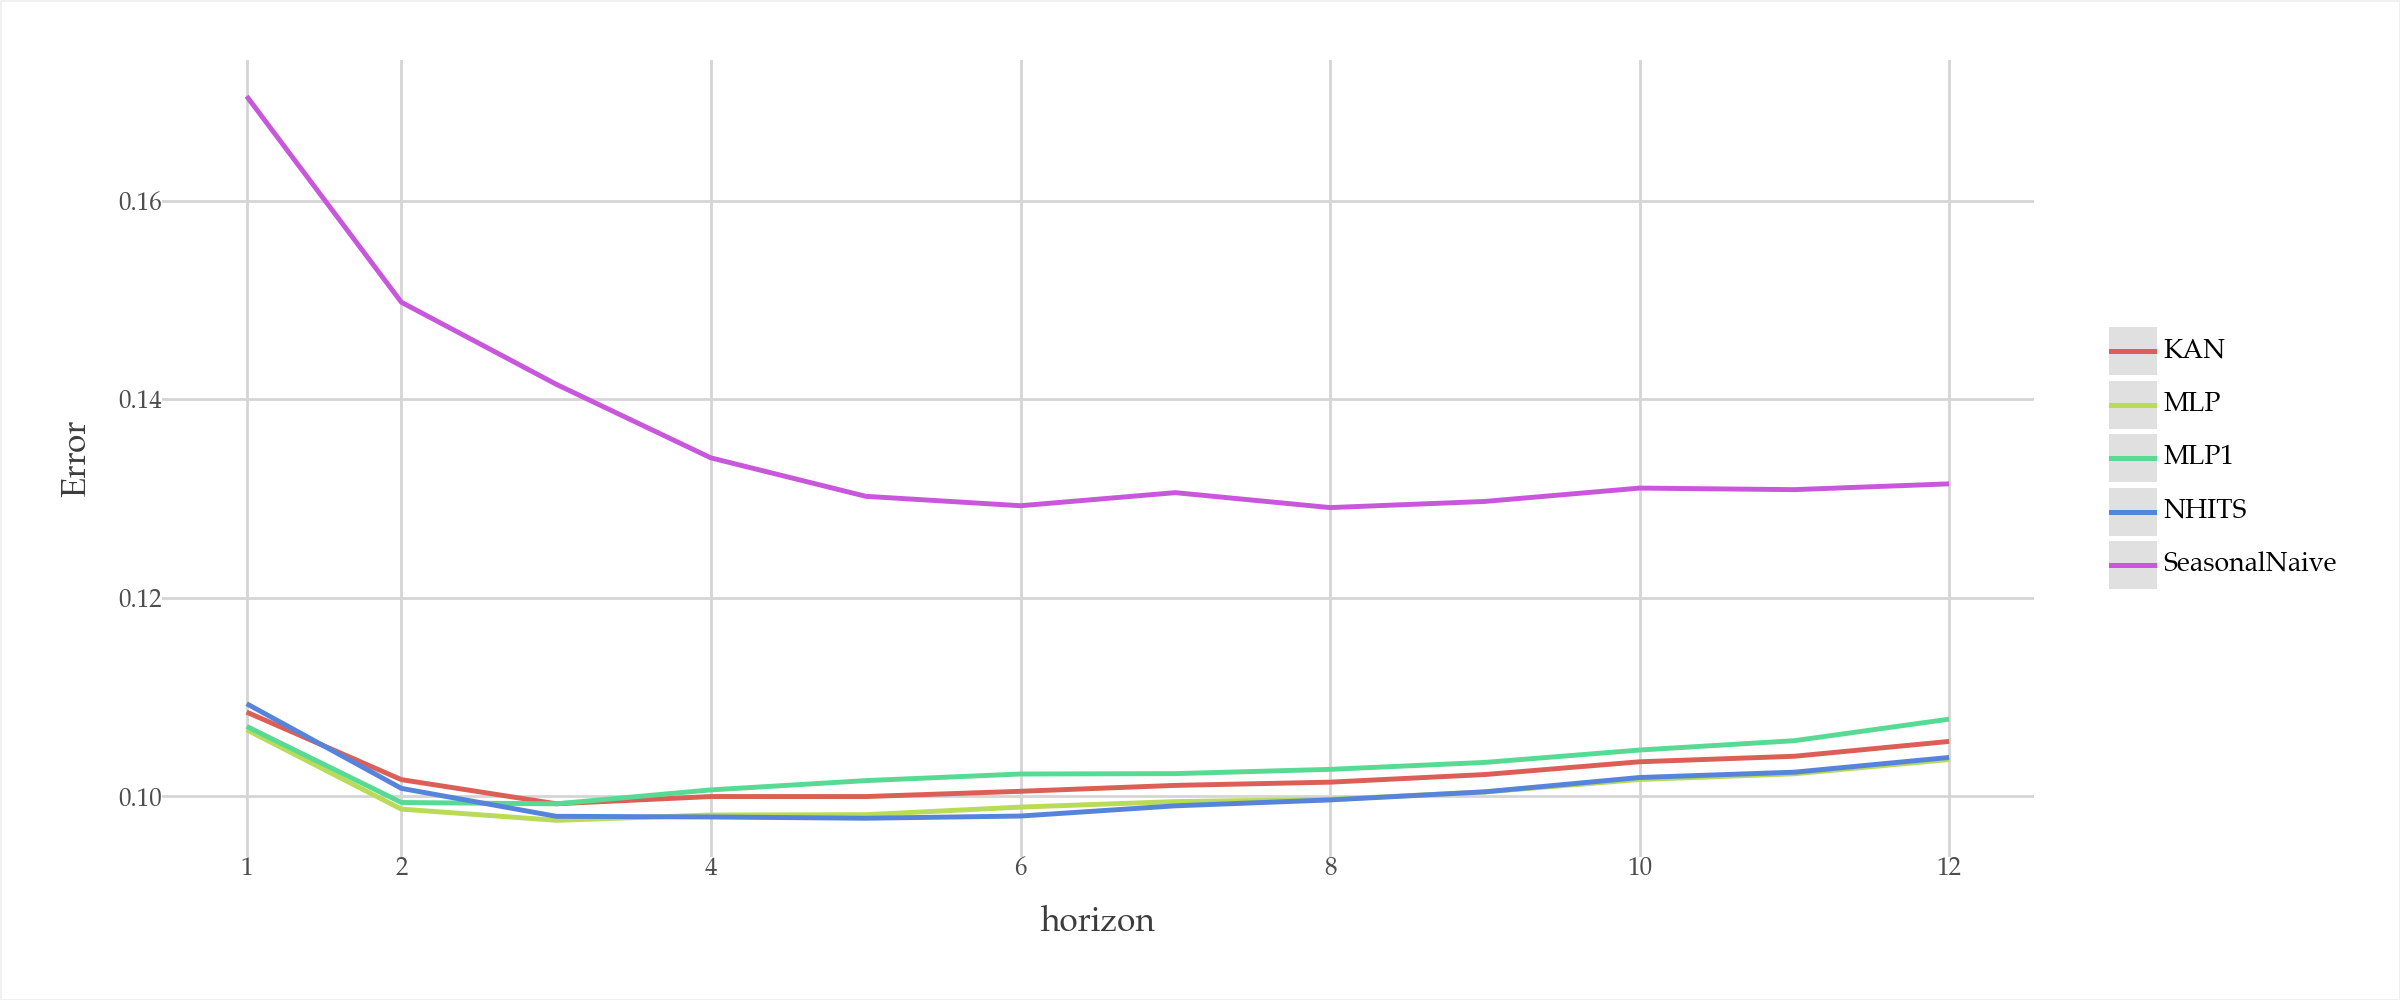

In [12]:
eval_fhorizon = radar.evaluate_by_horizon()

plot = radar.evaluate_by_horizon(return_plot=True)

plot + p9.theme(figure_size= (12,5))

#### Win/loss ratios

Using the performance across time series, you can compute the probability of each event (win/draw/loss) for a given reference model.

While MLP shows the best average accuracy, NHITS has a high probability of outperforming it. The difference in their accuracy is below 10% in about 49% of the time series.

               NHITS loses      draw  NHITS wins
MLP               0.175770  0.490896    0.333333
MLP1              0.223389  0.296218    0.480392
KAN               0.175070  0.472689    0.352241
SeasonalNaive     0.149160  0.179972    0.670868


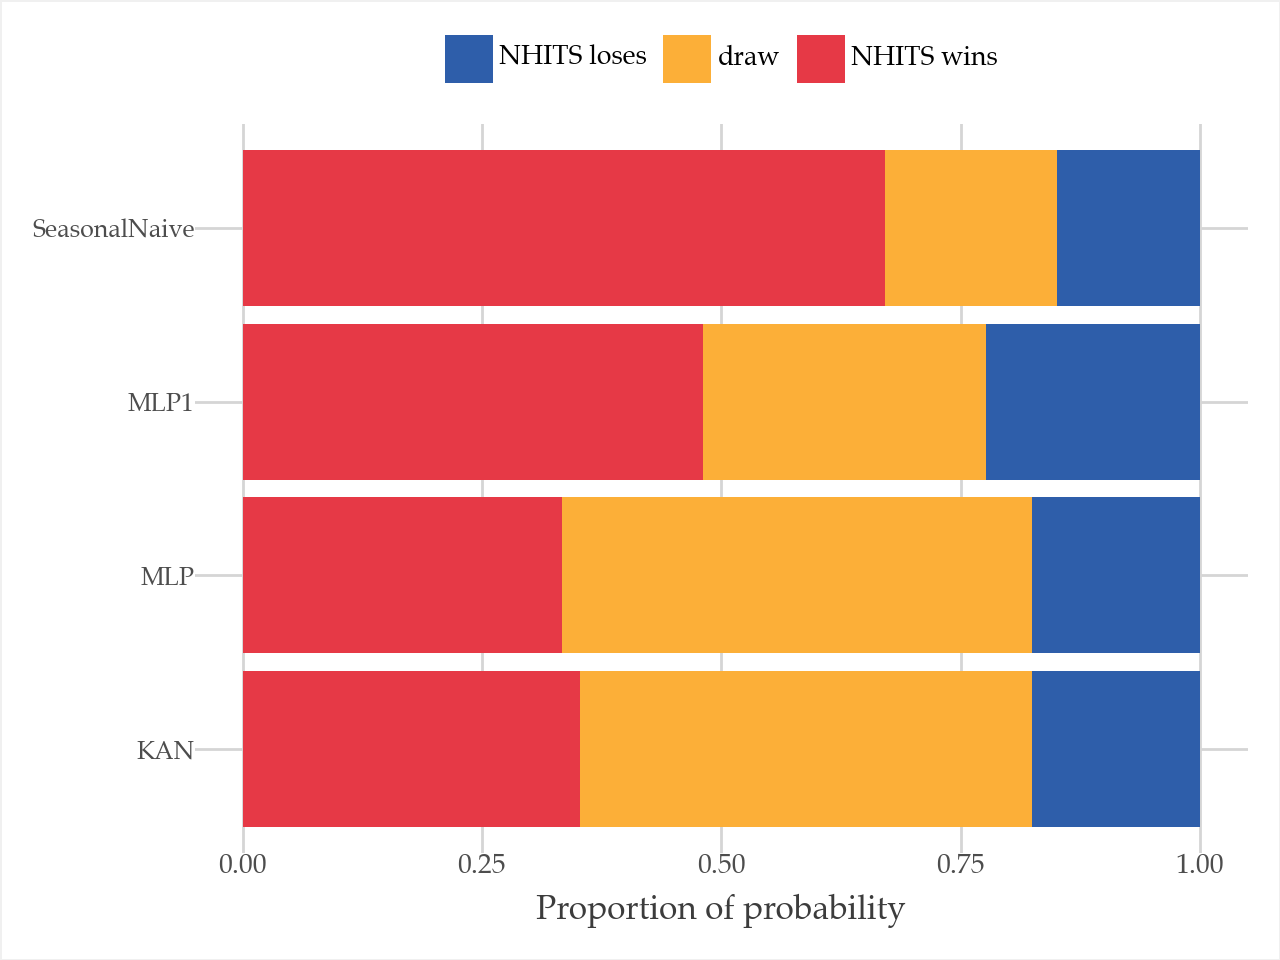

In [13]:
print(radar.rope.get_winning_ratios(err))

plot = radar.rope.get_winning_ratios(err, return_plot=True, reference=radar.rope.reference)

plot

#### Win/loss ratios on hard problems

On hard instances (err_hard) NHITS advantage is highlighted. In these cases, KAN is the most competitive model relative to NHITS

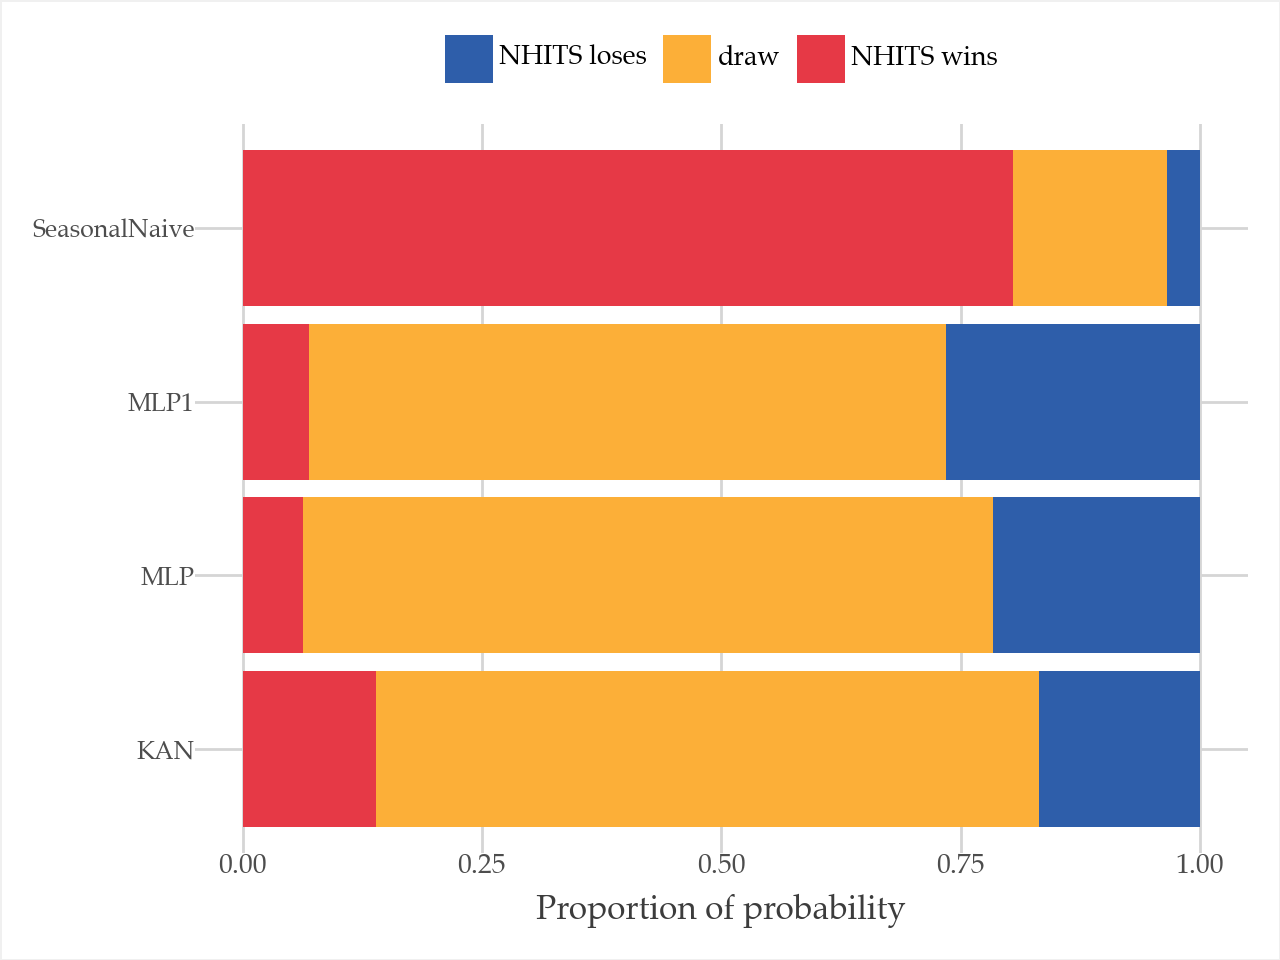

In [14]:
plot = radar.rope.get_winning_ratios(err_hard, return_plot=True, reference=radar.rope.reference)

plot

#### Expected shortfall

Another interesting accuracy summary is the expected shortfall, measuring the average accuracy on the worst 95% of cases (of each individual model). From this perspective, NHITS is more susceptible to large errors than other neural models.

NHITS            0.525496
MLP              0.501845
MLP1             0.498763
KAN              0.510183
SeasonalNaive    0.677590
Name: Exp. Shortfall, dtype: float64


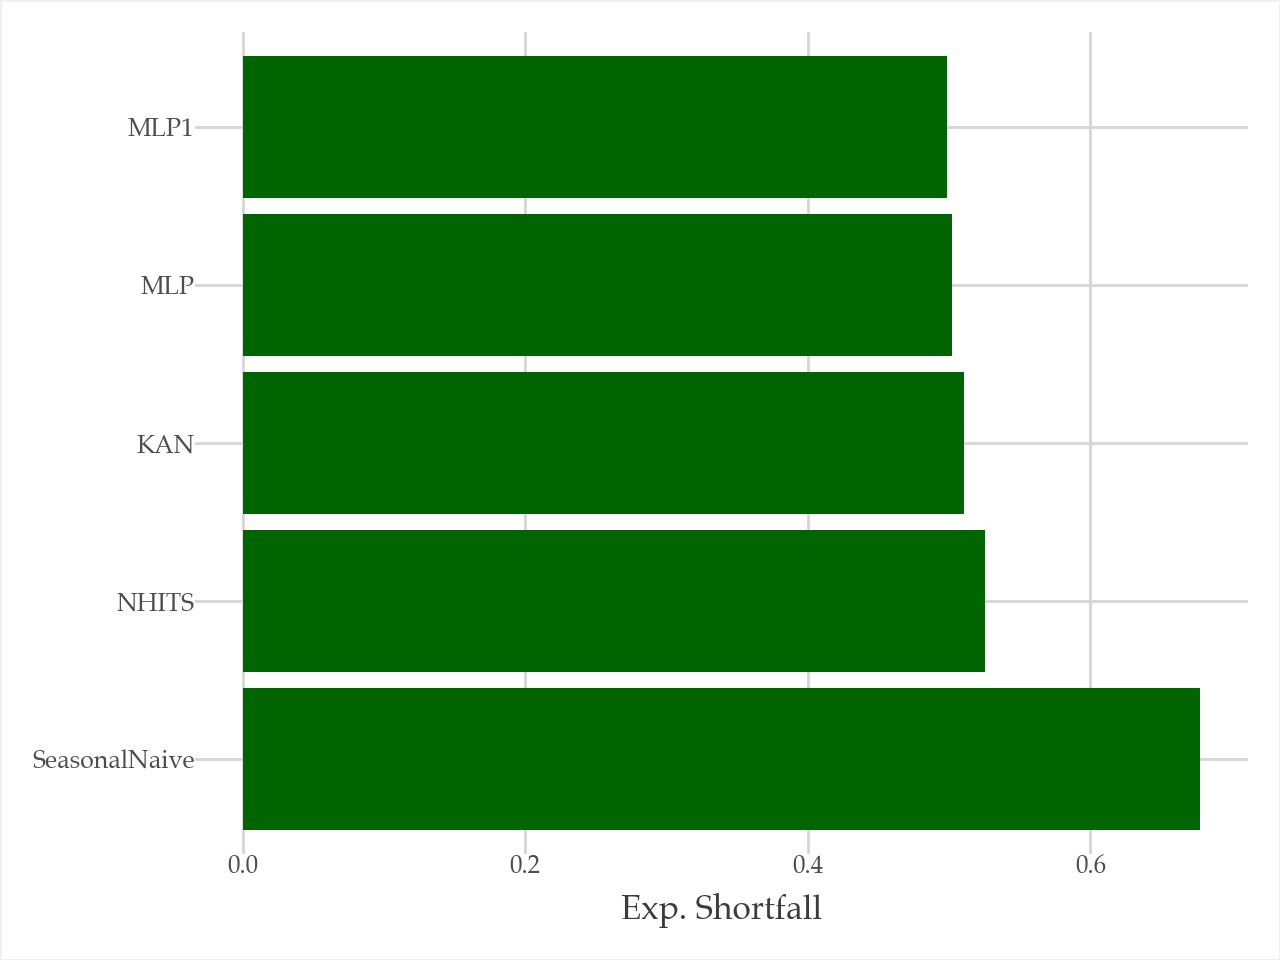

In [15]:
print(radar.uid_accuracy.expected_shortfall(err))

plot = radar.uid_accuracy.expected_shortfall(err, return_plot=True)

plot

#### Evaluation by predefined groups

You can evaluate accuracy controlling for predefined groups. 
Here's an example with the anomaly_status column.

               No anomalies  With anomalies
NHITS              0.100266        0.378495
MLP                0.099713        0.390048
MLP1               0.103815        0.389420
KAN                0.101355        0.407125
SeasonalNaive      0.125067        0.591078


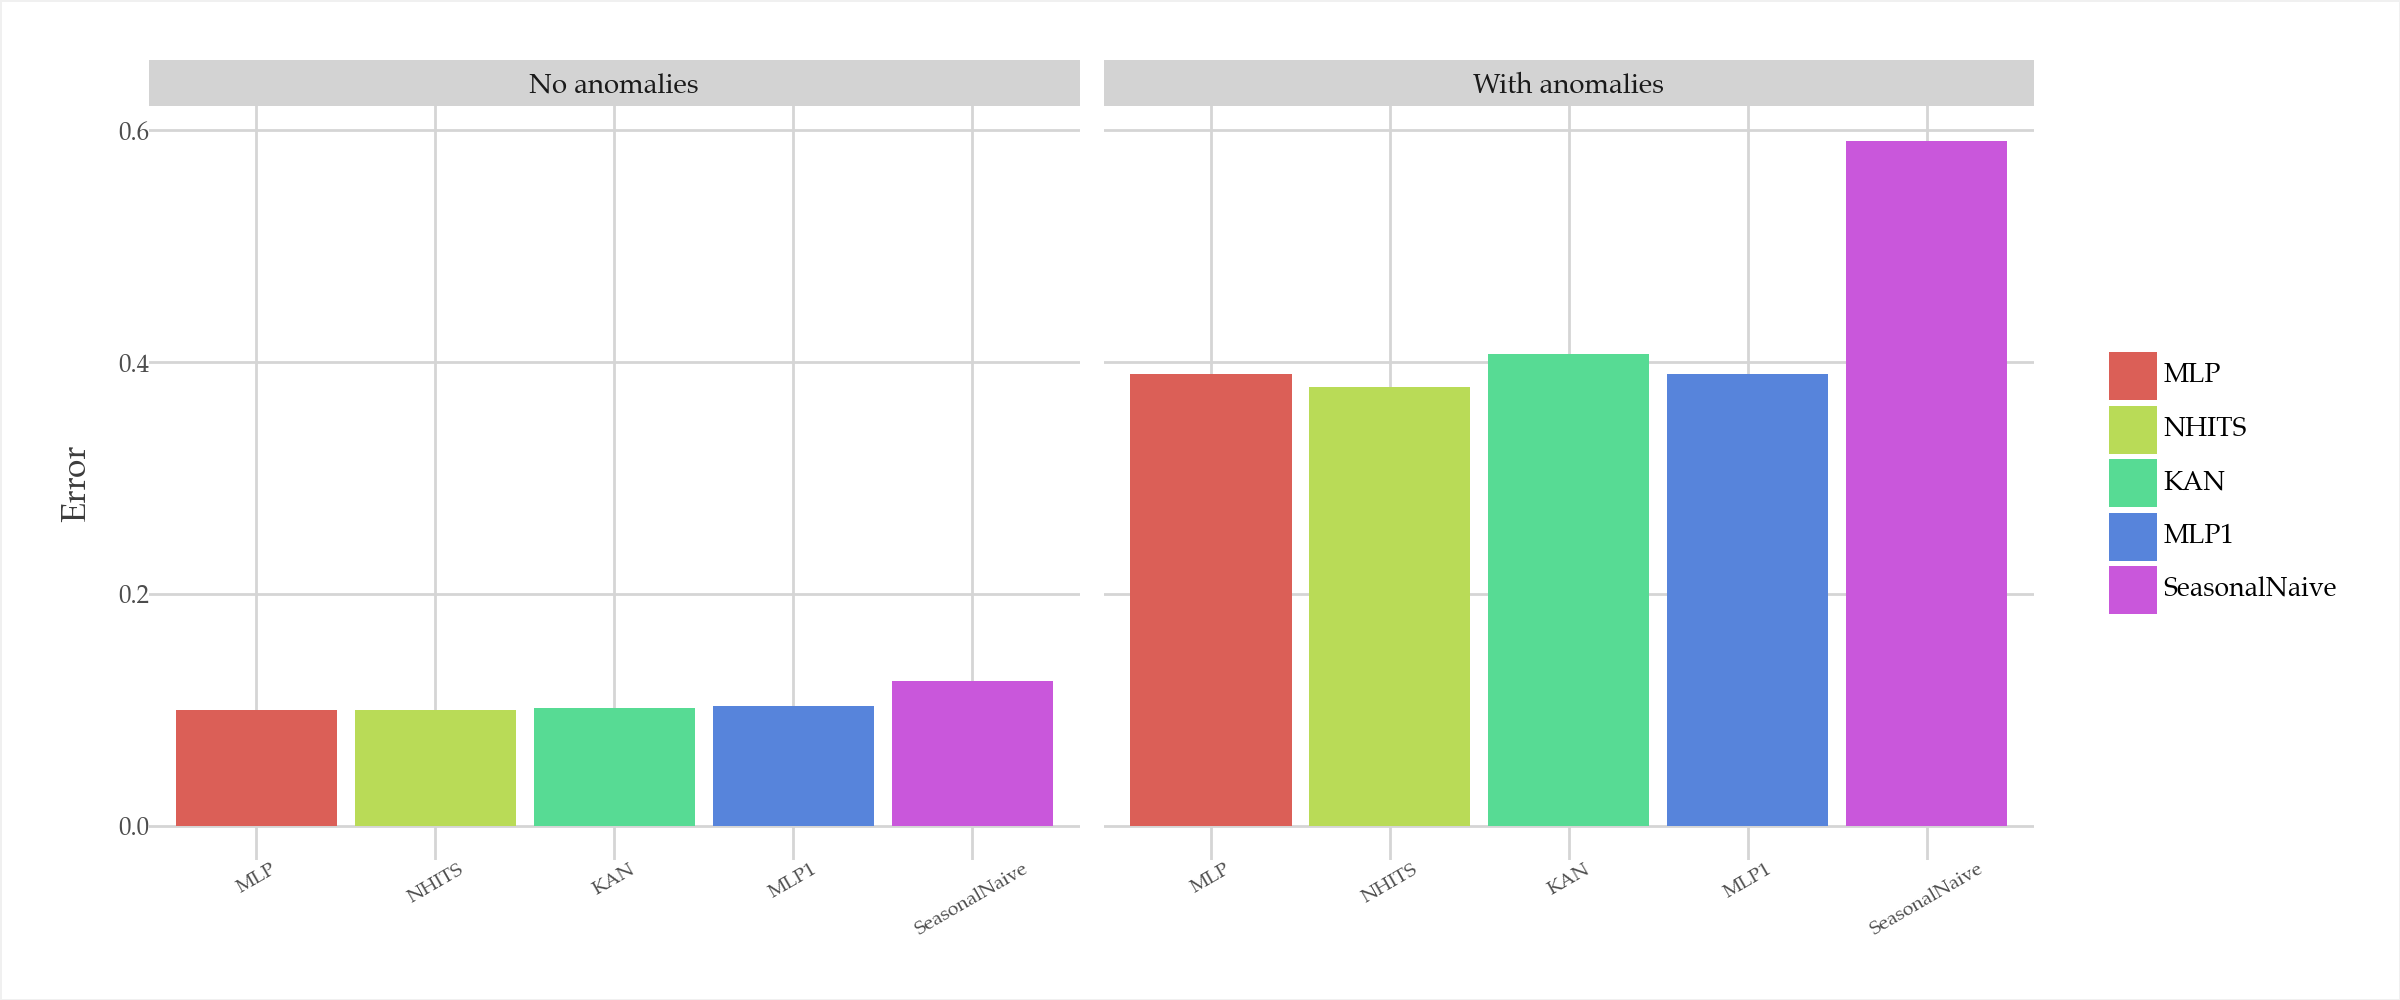

In [16]:
error_on_anomalies = radar.evaluate_by_group(group_col='anomaly_status')

print(error_on_anomalies)

plot = radar.evaluate_by_group(group_col='anomaly_status', return_plot=True, plot_model_cats=radar.model_order)

plot + p9.theme(figure_size= (12,5))

- The main take-away is: When no anomalies are present, all neural approaches perform comparably. Otherwise, MLP1 and NHITS perform the best.

- Finally, you can use ModelRadarPlotter.error_distribution to check the accuracy distribution across unique_ids:

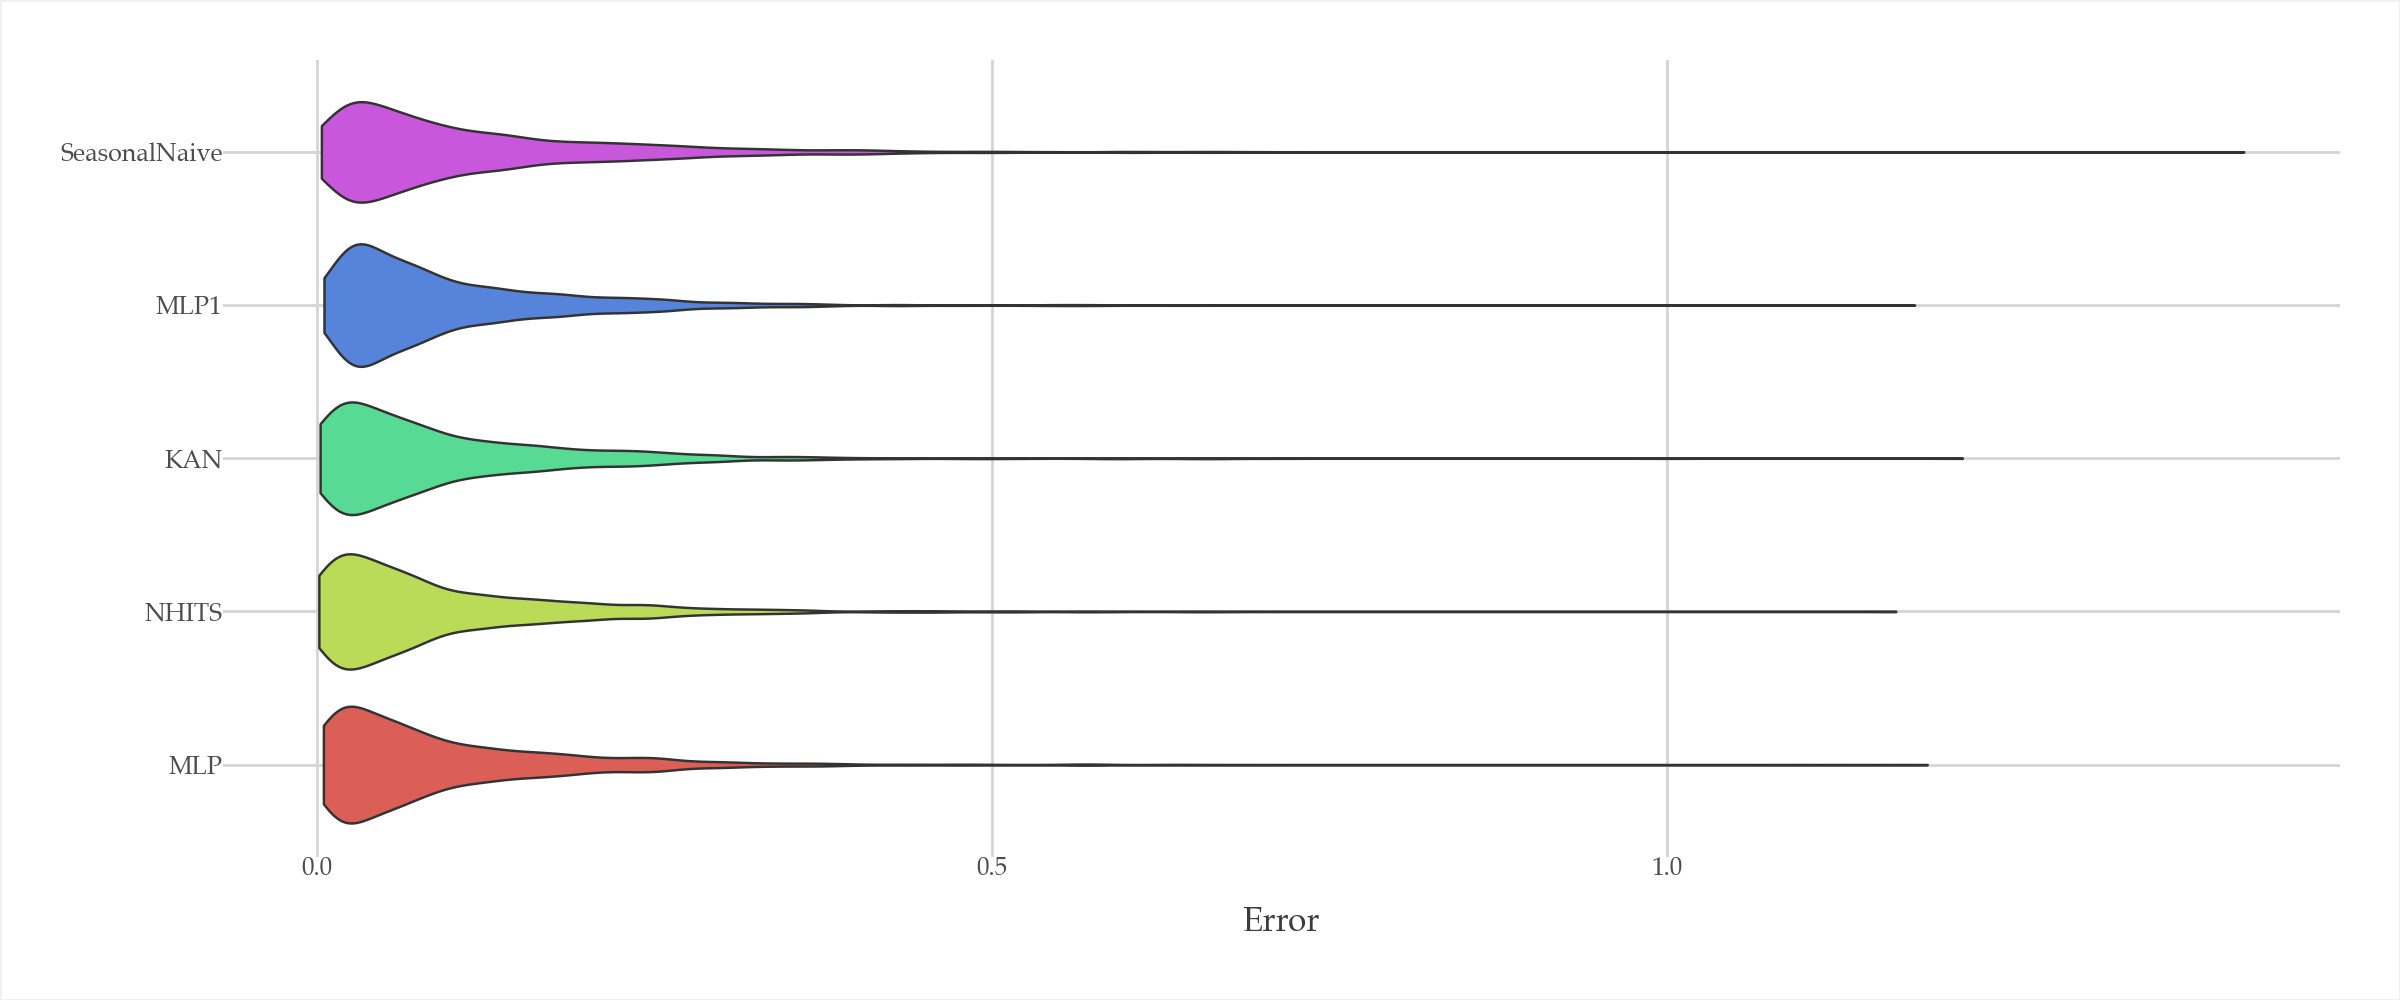

In [17]:
plot = ModelRadarPlotter.error_distribution(data=err, model_cats=radar.model_order, log_transform=True)

plot + p9.theme(figure_size= (12,5))

### Multi-dimension analysis plots

You can combine all analyses into a single plot.

In [18]:
df_plot = pd.concat([eval_overall,
                radar.uid_accuracy.expected_shortfall(err),
                eval_hbounds,
                radar.uid_accuracy.accuracy_on_hard(err),
                error_on_anomalies
                #error_on_trend,
                #error_on_seas
                    ], axis=1)

df_plot.head()

,Overall,Exp. Shortfall,One-step Ahead,Multi-step Ahead,On Hard,No anomalies,With anomalies
NHITS,0.103926,0.525496,0.109337,0.120247,0.386637,0.100266,0.378495
MLP,0.103718,0.501845,0.106710,0.119563,0.371749,0.099713,0.390048
MLP1,0.107780,0.498763,0.107053,0.131621,0.368002,0.103815,0.389420
KAN,0.105538,0.510183,0.108487,0.121960,0.380465,0.101355,0.407125
SeasonalNaive,0.131472,0.677590,0.170502,0.137894,0.508818,0.125067,0.591078


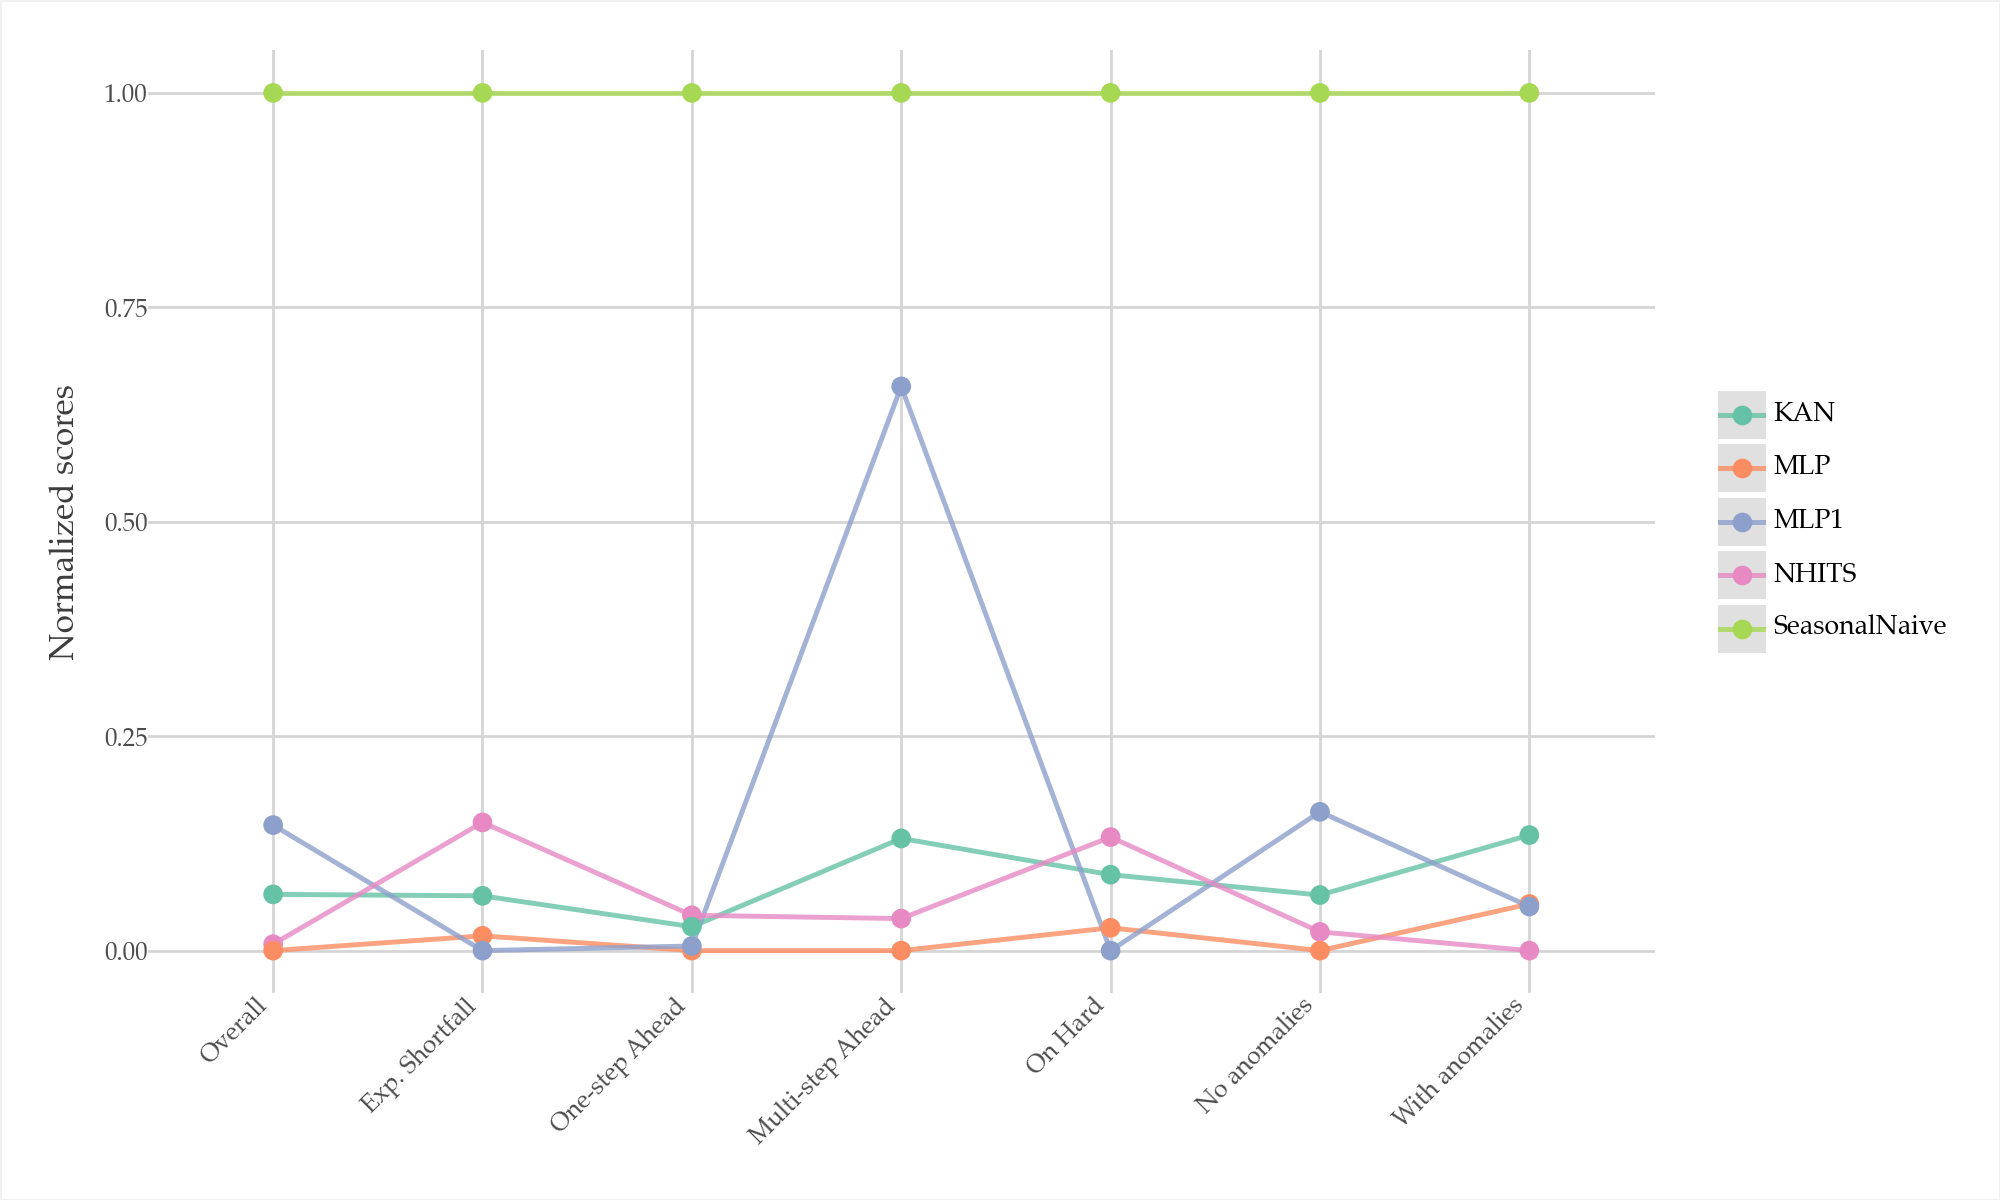

In [19]:
plot = ModelRadarPlotter.multidim_parallel_coords(df_plot, values='normalize')
plot

- In the above plot, we can see that MLP provides the best overall accuracy and where it is outperformed by other models in specific dimensions

- This plot can also be done using ranks (or raw values):

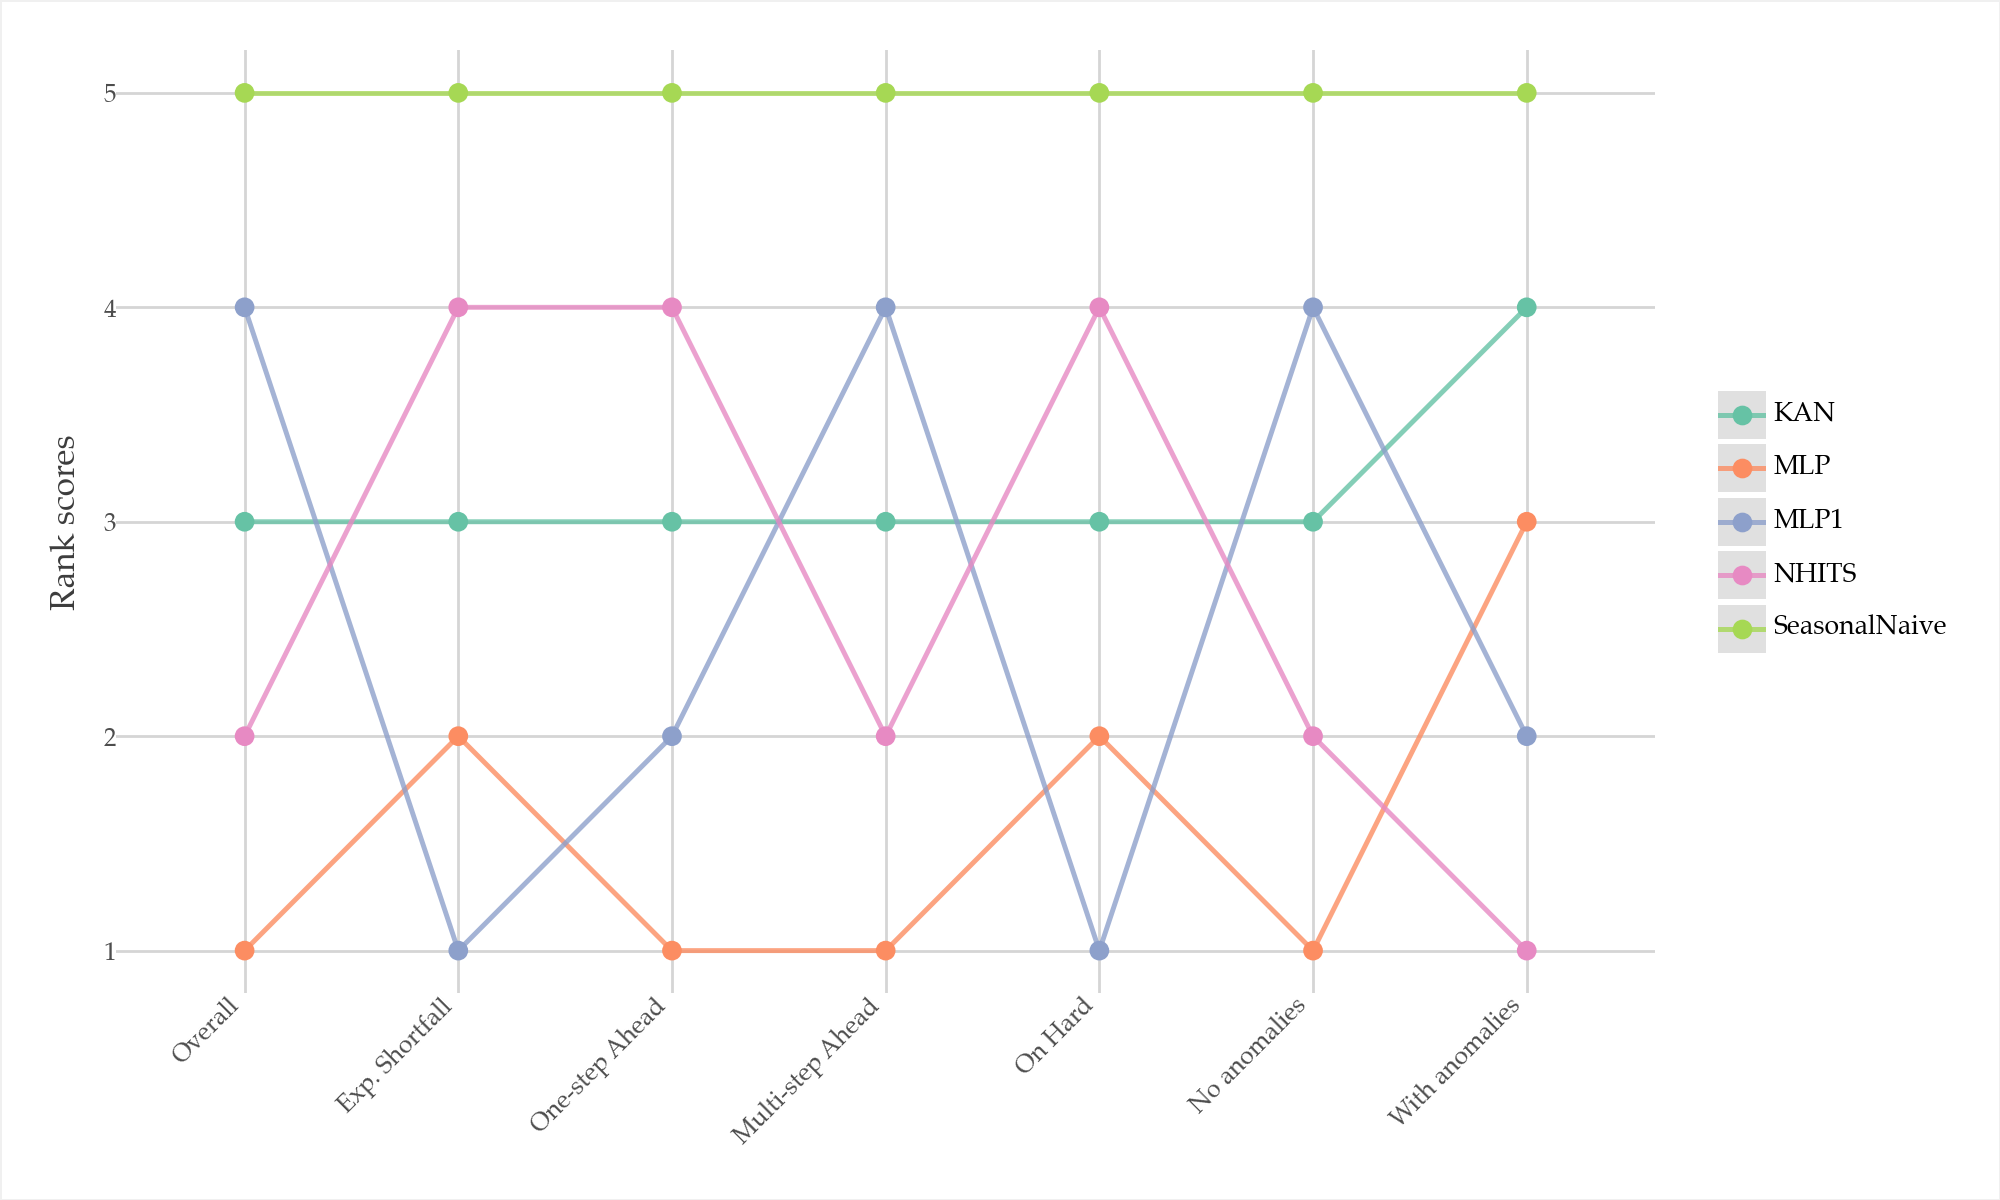

In [20]:
plot = ModelRadarPlotter.multidim_parallel_coords(df_plot, values='rank')
plot

- Spider plots can be used as alternative to parallel coordinate plots:

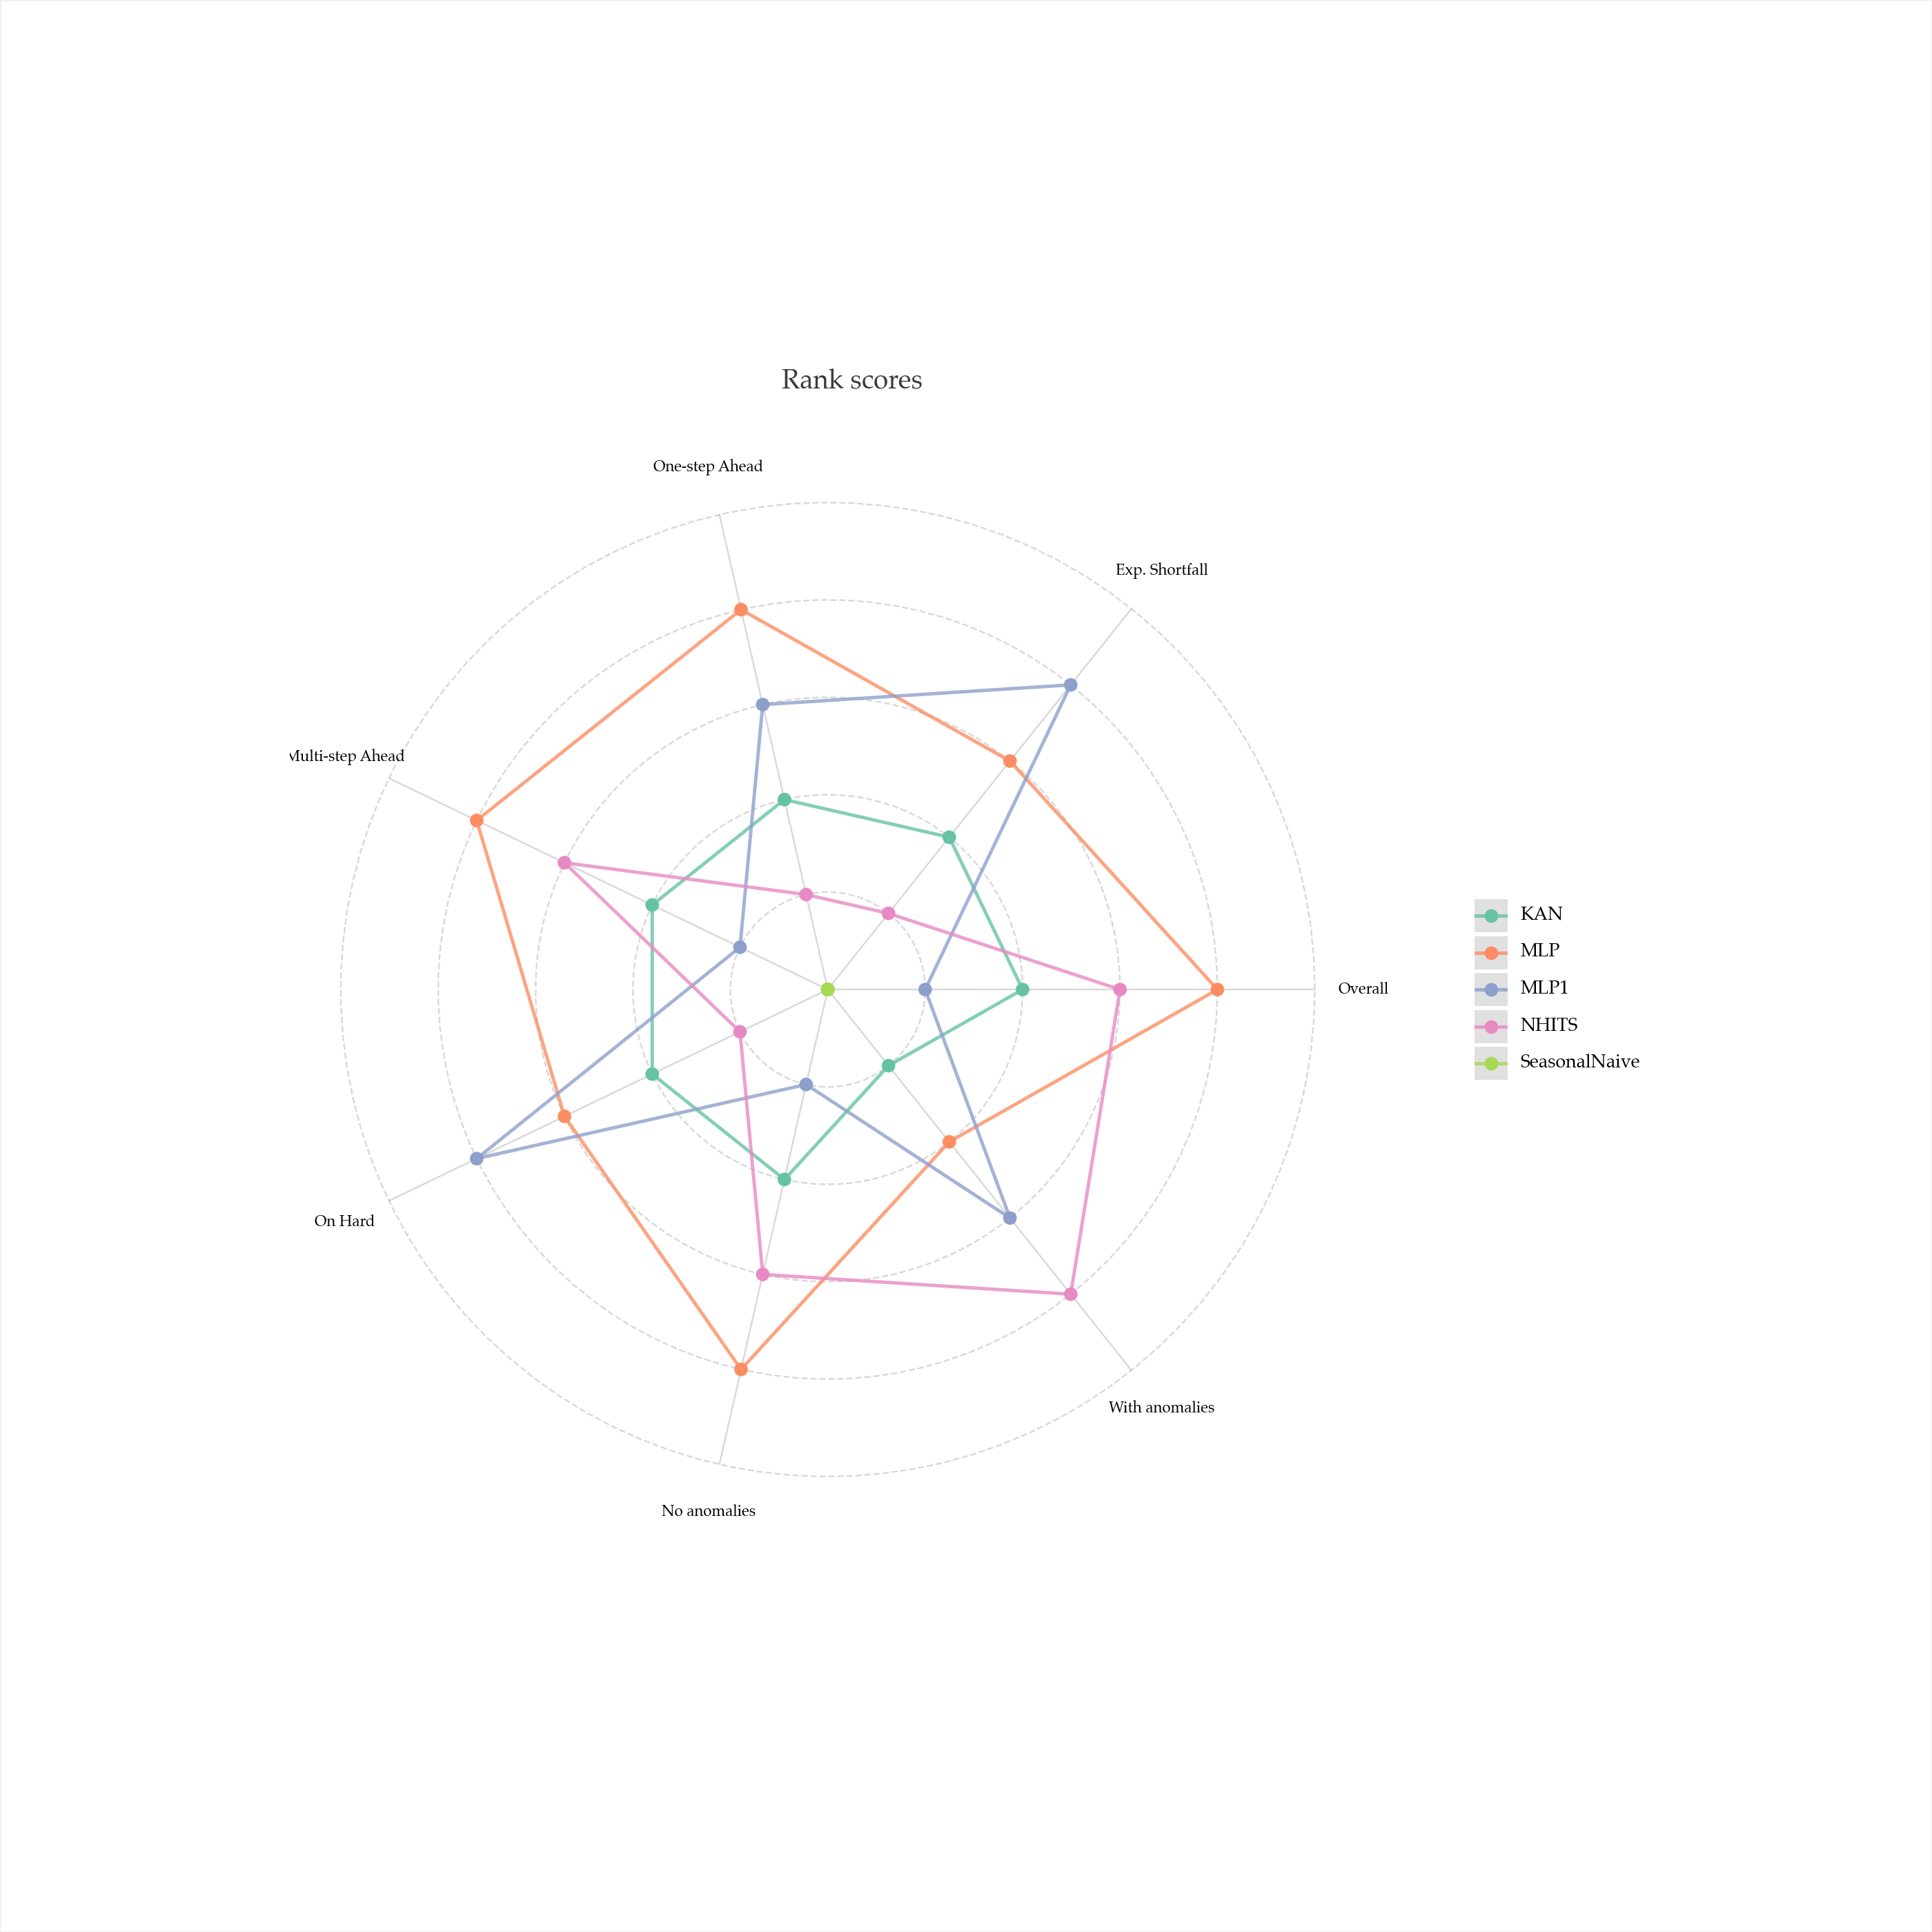

In [21]:
plot = SpiderPlot.create_plot(df=df_plot, values='rank')
plot

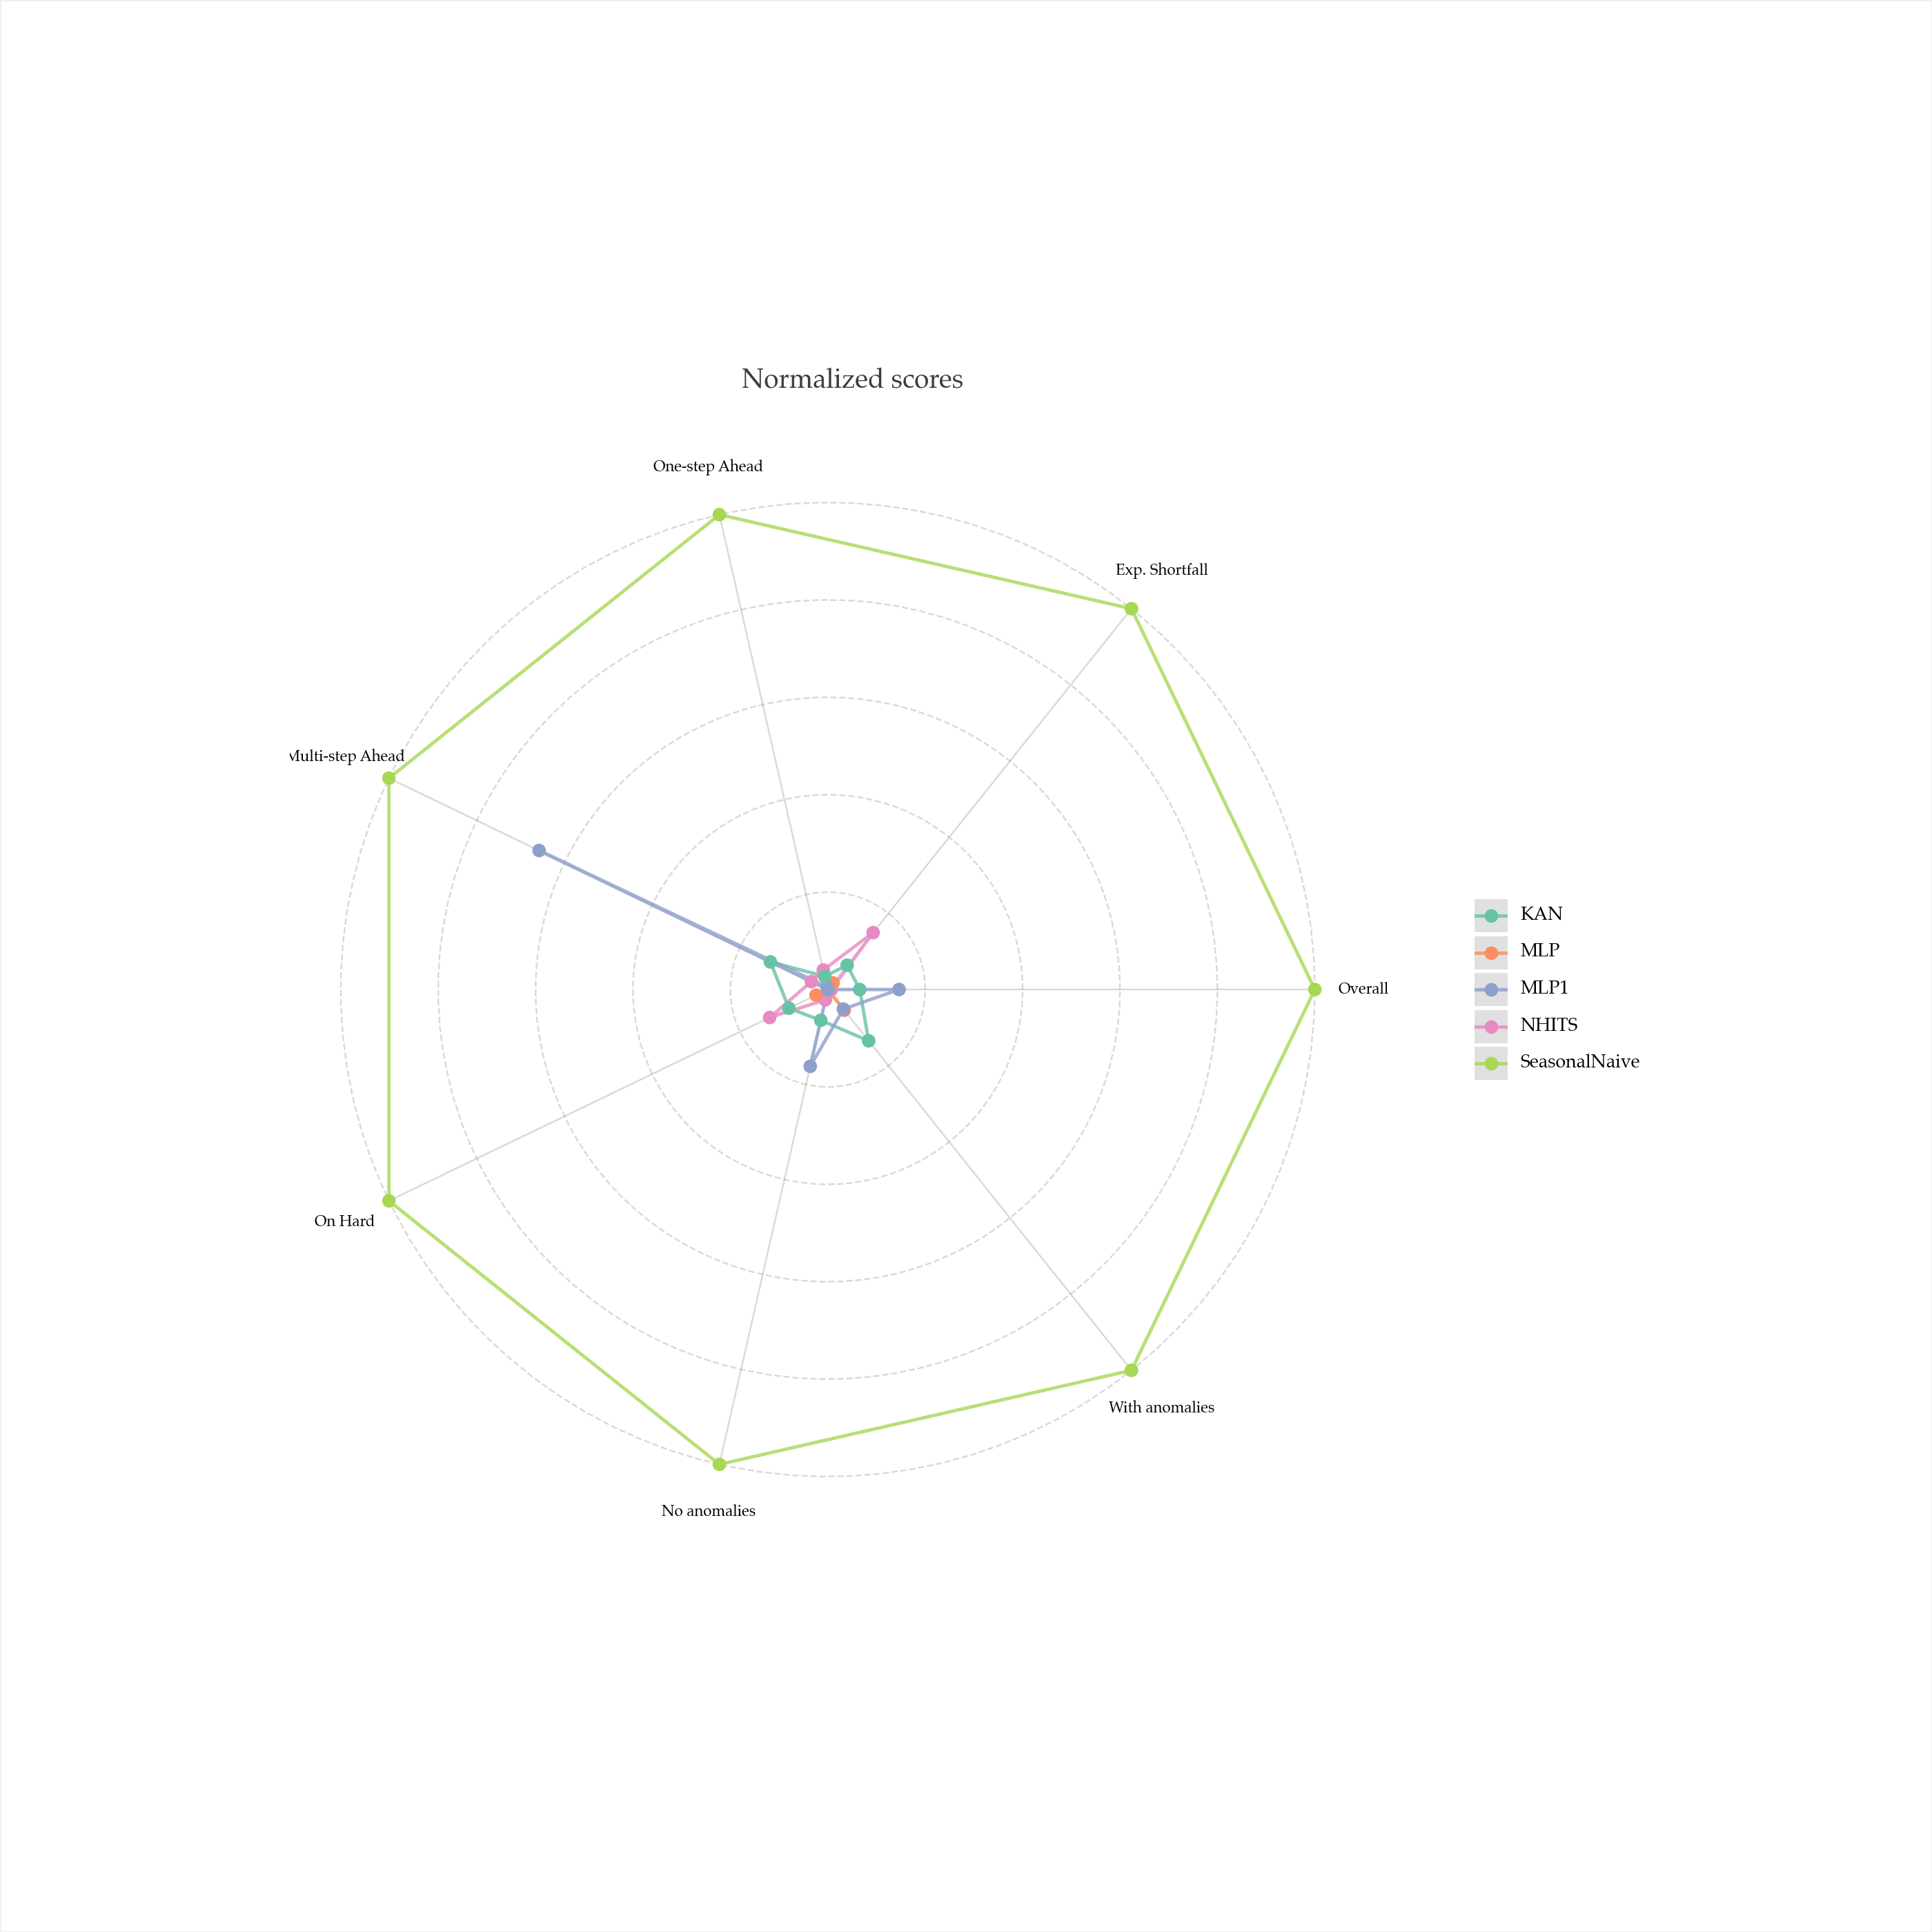

In [22]:
plot = SpiderPlot.create_plot(df=df_plot, values='normalize')
plot